# Anomaly detection

We'll work with the online shoppers purchase intention dataset located in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset)

To obtain the data, check the folder `prepare-data` in this repo, or section 2 in the course.

We'll see that customers that made a purchase are a minority. We will treat them as an anomaly, and train an unsupervised model for this demo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import balanced_accuracy_score as ba
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier, plot_tree

from feature_engine.selection import SmartCorrelatedSelection

## Prepare data

In [2]:
df = pd.read_csv("../online_shoppers_tree.csv")

print(df.shape)

df.head()

(12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,0,0,-1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,0,0,-1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,0,0,-1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,0,0,-1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,0,1,-1


In [3]:
# This variable is binary and indicates if a customer
# has made a purchase or not

df["Revenue"].value_counts(normalize=True)

Revenue
-1    0.845255
 1    0.154745
Name: proportion, dtype: float64

The people who purchase is not, strictly speaking an anomaly, it's still 15% of the customers, but for the demo, we'll treat them as an anomaly.

In [4]:
# split data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("Revenue", axis=1), 
    df["Revenue"], 
    test_size=0.3, 
    random_state=50,
)

X_train.shape, X_test.shape

((8631, 17), (3699, 17))

## Correlation

Let's find and remove correlated features first.

We know from the previous notebook that there are a few.

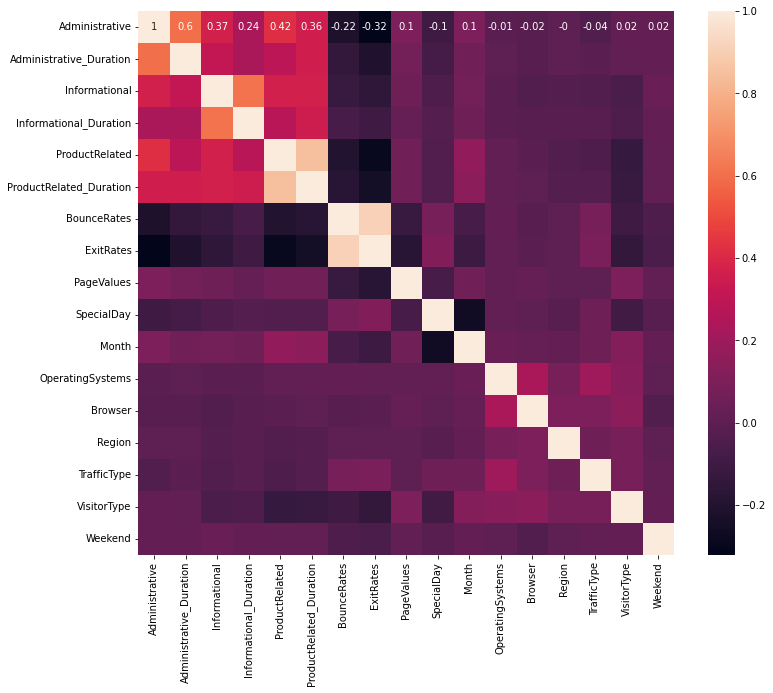

In [5]:
# We calculate the correlations using pandas corr()
# and we round the values to 2 decimals.

correlation_matrix = X_train.corr().round(2)

# Plot the correlation matrix usng seaborn.
# We use annot = True to print the correlation values
# inside the squares.

figure = plt.figure(figsize=(12, 10))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

In [6]:
# Find correlated features.

sel = SmartCorrelatedSelection(
    threshold=0.7,
    selection_method='variance',
)

sel.fit(X_train, y_train)

# correlated variables
sel.correlated_feature_sets_

[{'ProductRelated', 'ProductRelated_Duration'}, {'BounceRates', 'ExitRates'}]

There are 2 pair of correlated features. Let's plot them against each other.

In [7]:
X_train['ProductRelated'].max()

705

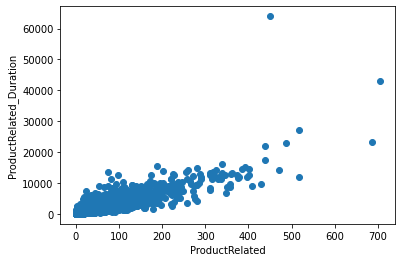

In [8]:
plt.scatter(X_train['ProductRelated'], X_train['ProductRelated_Duration'])
plt.xlabel('ProductRelated')
plt.ylabel('ProductRelated_Duration')
plt.show()

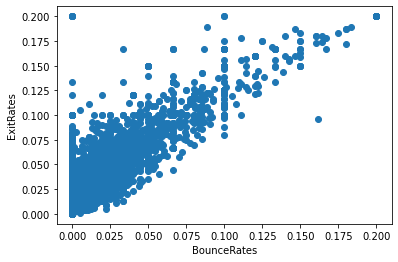

In [9]:
plt.scatter(X_train['BounceRates'], X_train['ExitRates'])
plt.xlabel('BounceRates')
plt.ylabel('ExitRates')
plt.show()

In [10]:
# Retain variable with highest variability from
# each pair.

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((8631, 15), (3699, 15))

## Anomaly detection with One Class SVM

Let's fit a One Class Support Vector Machine, using grid search to find the best configuration.

In [11]:
# set up the one class SVM classifier
clf = OneClassSVM(gamma='auto')

# set up the grid of hyperparameters to examine
param_grid = {
    "kernel": ("poly", "rbf"),
    "gamma": ["scale", "auto", 0.1, 0.5],
    "nu": [0.1, 0.5, 0.7]
}

# tune
search = GridSearchCV(
    clf,
    param_grid,
    cv=3,
    scoring="balanced_accuracy",
    refit=True,
    verbose=True,
)

# train and evaluate
search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=OneClassSVM(gamma='auto'),
             param_grid={'gamma': ['scale', 'auto', 0.1, 0.5],
                         'kernel': ('poly', 'rbf'), 'nu': [0.1, 0.5, 0.7]},
             scoring='balanced_accuracy', verbose=True)

In [12]:
# the best balanced accuracy obtained
search.best_score_

0.6343976356179413

In [13]:
# the best hyperparameters

search.best_params_

{'gamma': 'auto', 'kernel': 'poly', 'nu': 0.5}

In [14]:
# the best one class SVM

ocsvm = search.best_estimator_

In [15]:
print(classification_report(y_test, ocsvm.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.91      0.53      0.67      3127
           1       0.22      0.72      0.34       572

    accuracy                           0.56      3699
   macro avg       0.56      0.62      0.50      3699
weighted avg       0.80      0.56      0.62      3699



In [16]:
print(f"Balanced-accuracy in train set: {ba(y_train, ocsvm.predict(X_train))}")
print(f"Balanced-accuracy in test set: {ba(y_test, ocsvm.predict(X_test))}")

Balanced-accuracy in train set: 0.6342001227155012
Balanced-accuracy in test set: 0.6240668908961202


In [17]:
print(f"Accuracy in train set: {accuracy_score(y_train, ocsvm.predict(X_train))}")
print(f"Accuracy in test set: {accuracy_score(y_test, ocsvm.predict(X_test))}")

Accuracy in train set: 0.570269957131271
Accuracy in test set: 0.5612327656123277


The model is not amazing, but is better than the baseline at least.

Explaining a mediocre model is only going to provide mediocre insights, that is something to keep in mind.

## Train surrogate (Decision tree) 

Let's now try to explain the results of the One Class SVM with a decision tree.

In [18]:
# Train a surrogate to predict the predictions of 
# the one class SVM

surrogate = DecisionTreeClassifier(random_state=0, max_depth=2)

surrogate.fit(X_train, ocsvm.predict(X_train))

DecisionTreeClassifier(max_depth=2, random_state=0)

In [19]:
print(
    f"Balanced accuracy in train set: {ba(ocsvm.predict(X_train), surrogate.predict(X_train))}")
print(
    f"Balanced accuracy in test set: {ba(ocsvm.predict(X_test), surrogate.predict(X_test))}")

Balanced accuracy in train set: 0.9951333366266564
Balanced accuracy in test set: 0.9951845906902086


In [20]:
print(
    f"Accuracy in train set: {accuracy_score(ocsvm.predict(X_train), surrogate.predict(X_train))}")
print(
    f"Accuracy in test set: {accuracy_score(ocsvm.predict(X_test), surrogate.predict(X_test))}")

Accuracy in train set: 0.9951338199513382
Accuracy in test set: 0.9951338199513382


In [21]:
# evaluate how faithfull the surrogate is to the ocsvm

print(classification_report(ocsvm.predict(X_test), surrogate.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.99      1.00      1.00      1830
           1       1.00      0.99      1.00      1869

    accuracy                           1.00      3699
   macro avg       1.00      1.00      1.00      3699
weighted avg       1.00      1.00      1.00      3699



## Global explanations

- Tree diagram
- Tree importance
- Permutation feature importance
- Partial dependence plots

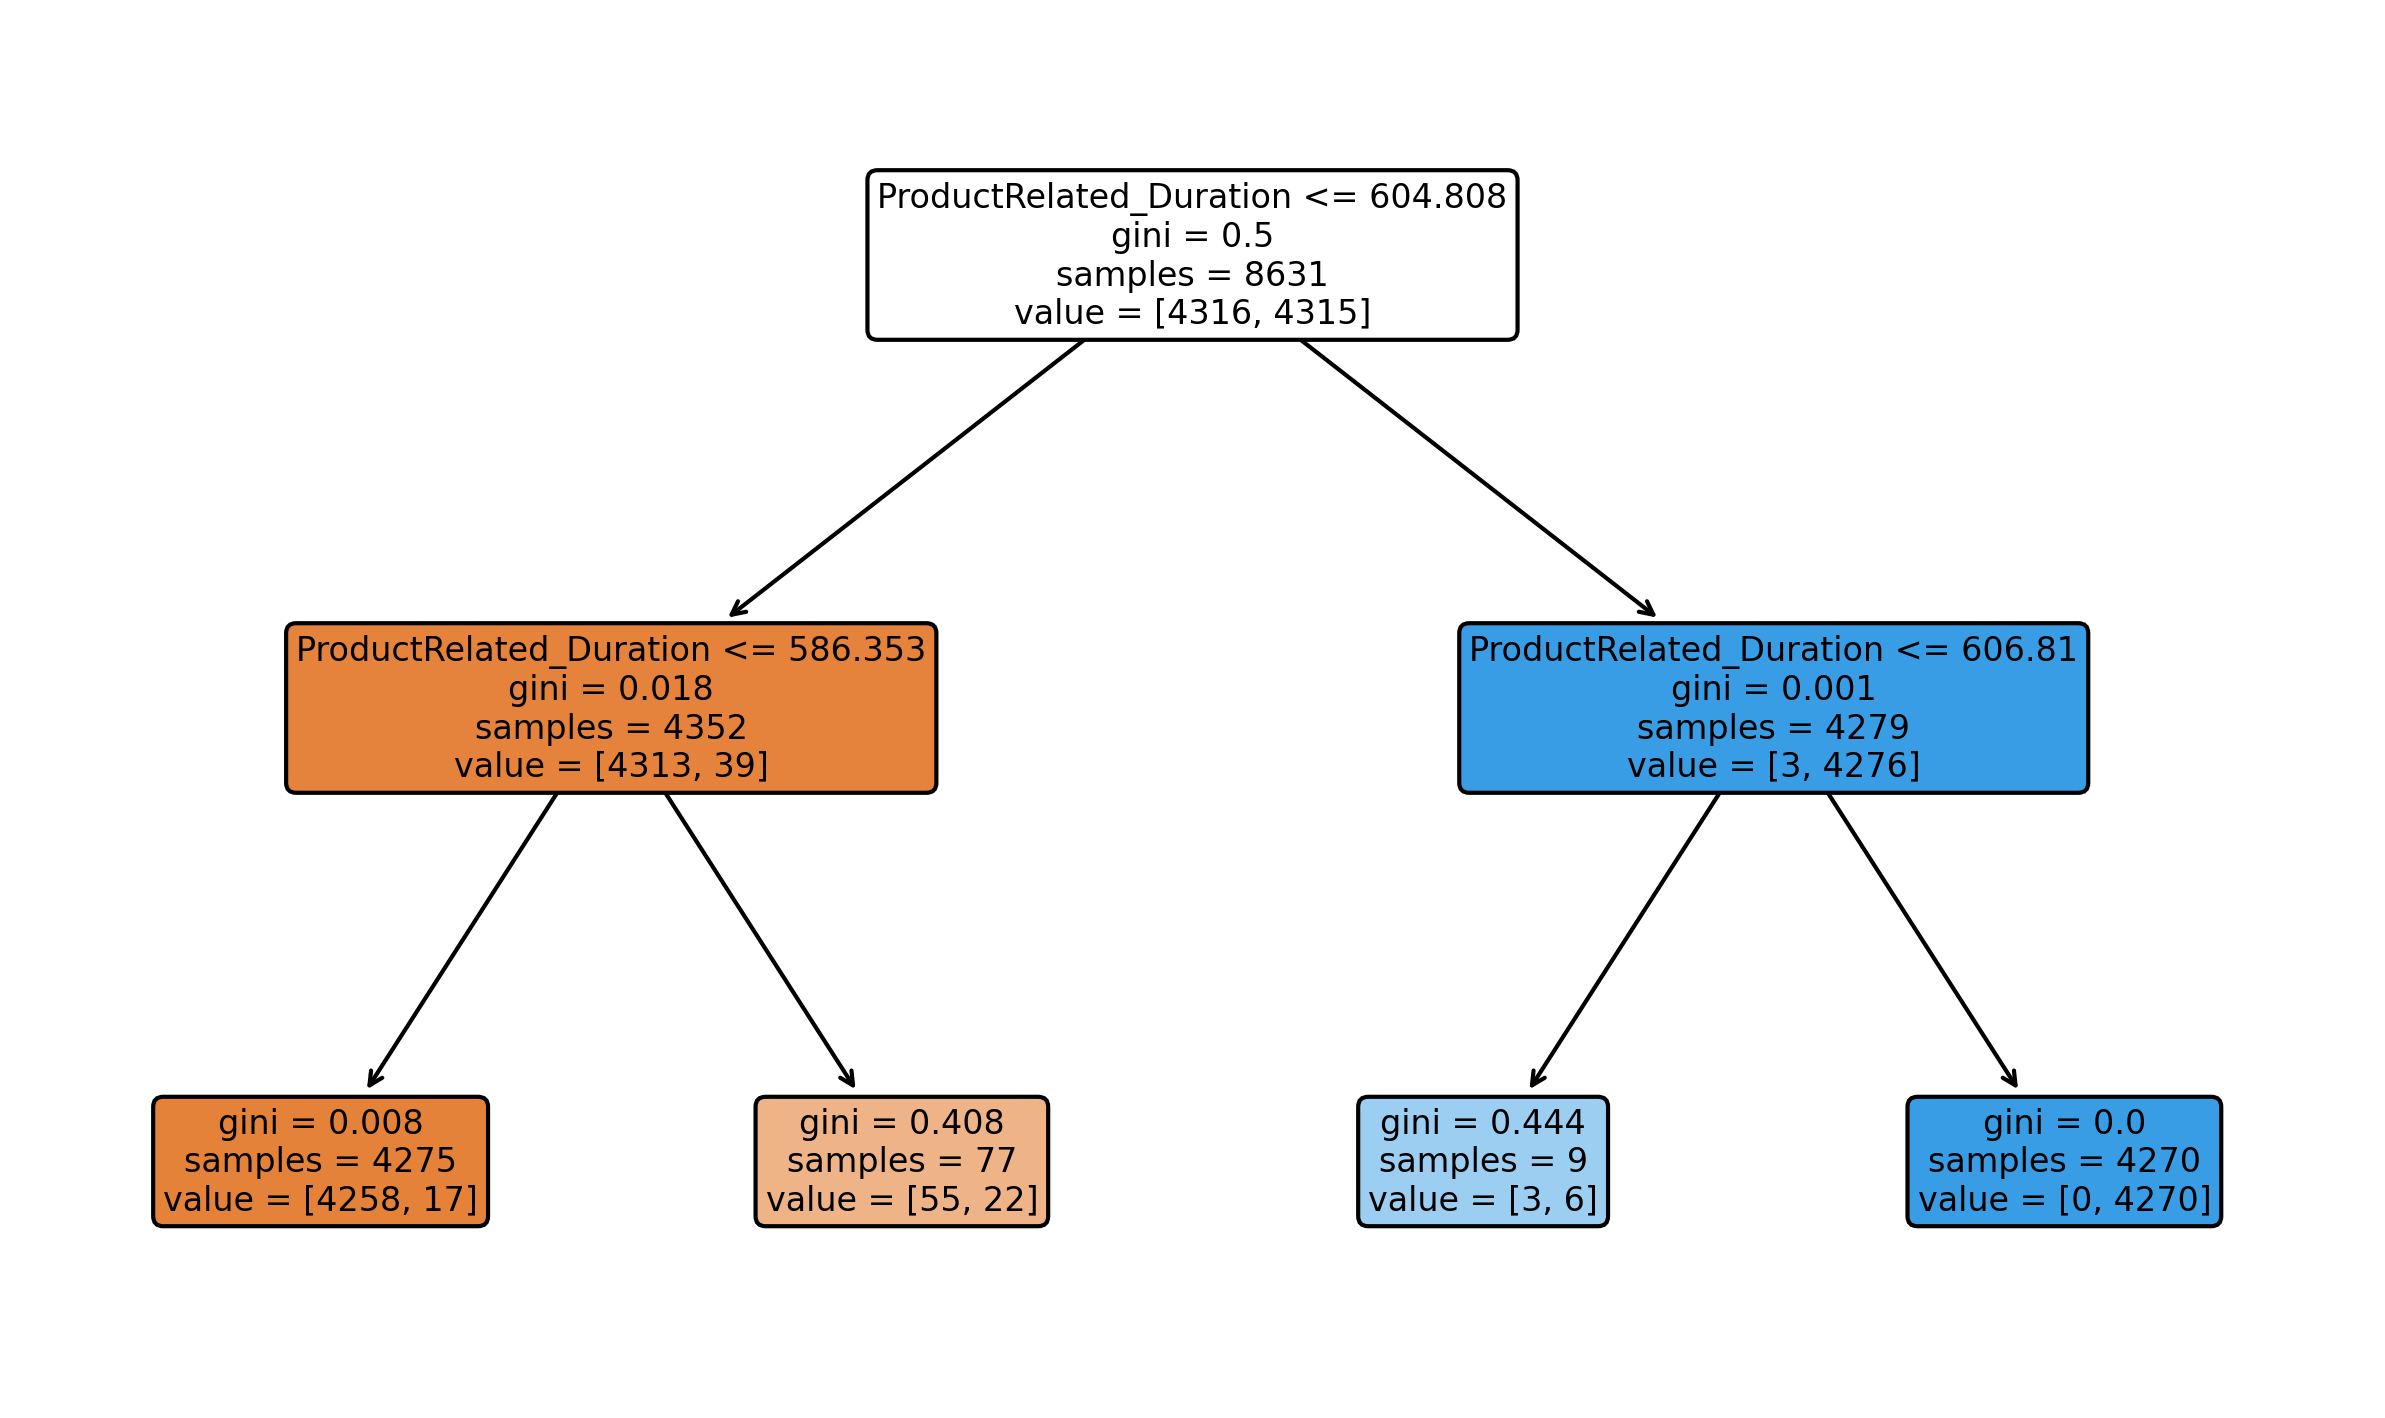

In [22]:
# plot the tree

plt.figure(figsize=(10, 6), dpi=300)

plot_tree(
    decision_tree = surrogate,
    feature_names=X_train.columns.to_list(),
    filled=True, # color the squares
    rounded=True, # round squares
    fontsize=8,
)

plt.show()

This tree thinks that the only important feature is `ProductRelated_Duration`.

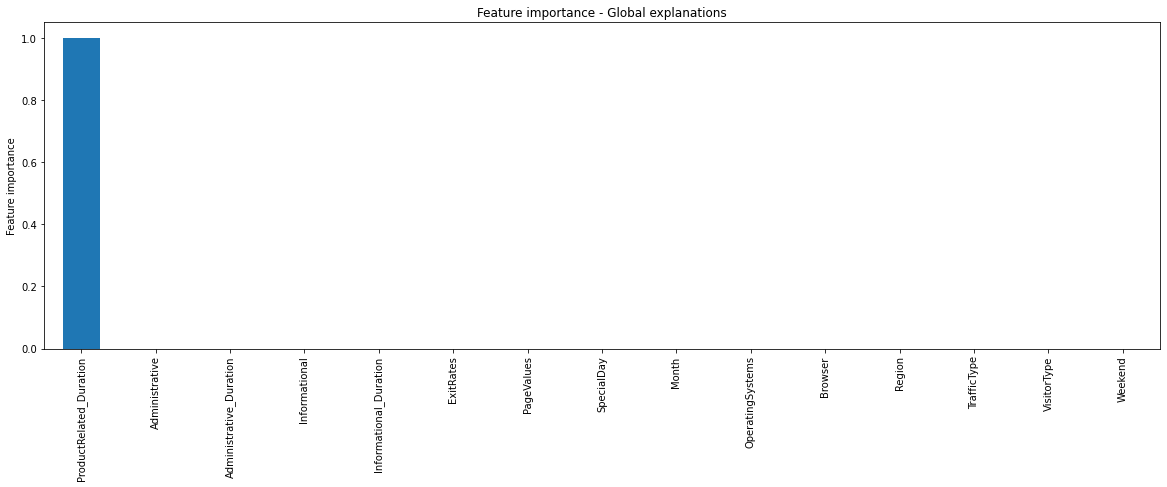

In [23]:
# tree derived global importance

global_exp = pd.Series(
    surrogate.feature_importances_,
    index=surrogate.feature_names_in_)

global_exp.sort_values(ascending=False).plot.bar(figsize=(20,6))
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.show()

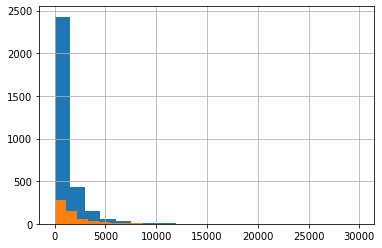

In [24]:
# Let's plot the distribution of this variable within
# the classes

X_test.groupby(y_test)["ProductRelated_Duration"].hist(bins=20)
plt.show()

I am not convinced that this is the only variable. Let's explore more.

## Permutation feature importance

In [25]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    ocsvm, 
    X_test, # we use the test set
    y_test,
    scoring= "balanced_accuracy", # we can use any metric
    n_repeats=3, 
    random_state=0,
)

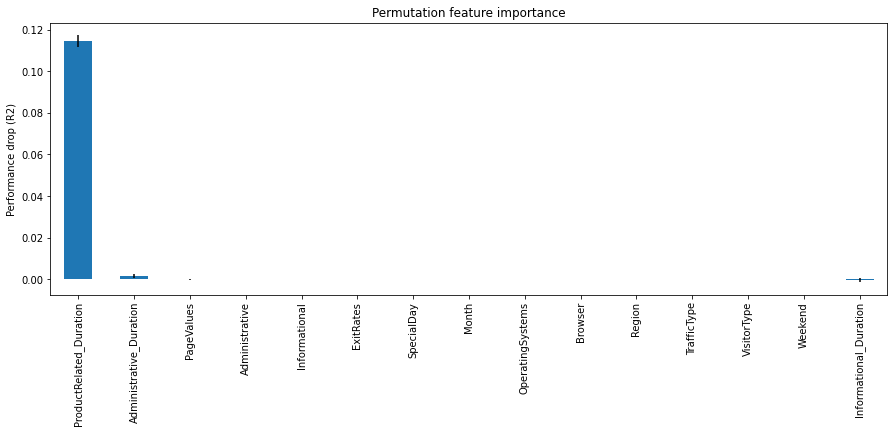

In [26]:
# contains is an array of arrays
# contains the individual importance of each repetition#
# and the mean and std

importance = pd.DataFrame(
    {"importance_mean": r["importances_mean"],
     "importance_std": r["importances_std"]},
    index=ocsvm.feature_names_in_)

# The larger the drop, the more important the feature

importance["importance_mean"].sort_values(
    ascending=False
).plot(figsize=(15, 5), kind="bar", yerr=importance["importance_std"])

plt.title("Permutation feature importance")
plt.ylabel("Performance drop (R2)")
plt.show()

Actually, the tree is not too far off. Never neglect the power of a surrogate. If we increased the depth of the tree, perhaps it picks up the other 2 variables as well.

In [27]:
# partial dependence plots
# we need to use our own function, because sklearn only
# works with regressors and classifiers, and xcsvm is none
# probably because it lacks the method "predict_proba"

from sklearn.inspection import PartialDependenceDisplay

def plot_pdp(X, variable, bins=5):
    
    # to avoid modifying the original dataframe
    X = X.copy()
    
    # sort variable into bins
    bins = pd.qcut(X[variable], q=bins, duplicates="drop")
    
    # determine interval's middle point and n of observations
    pdp = X.groupby(bins, observed=False)[variable].agg(["mean", "count"])
    
    # calculate partial dependence
    pdp_preds = []
    for value in pdp["mean"]:
        X[variable] = value
        preds = ocsvm.predict(X)
        pdp_preds.append(np.mean(preds))
    pdp["pdp_preds"] = pdp_preds
    
    # plot
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    ax2 = ax.twinx()

    pdp["count"].plot.bar(ax=ax)
    pdp["pdp_preds"].plot(ax=ax2, color="r")

    plt.title(f"Partial dependence plot - {variable}")
    ax.set_ylabel("Number of observations")
    ax2.set_ylabel("Partial dependence")
    plt.show()

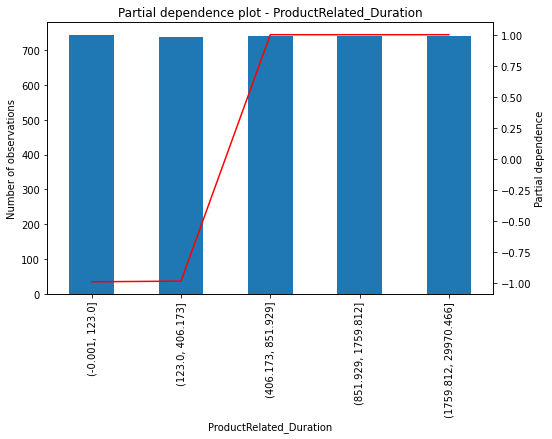

In [28]:
# most important variable

plot_pdp(X_test, "ProductRelated_Duration")

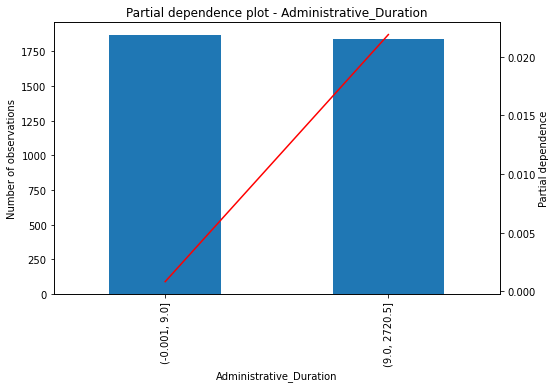

In [30]:
# second most important variable

plot_pdp(X_test, "Administrative_Duration", bins=2)

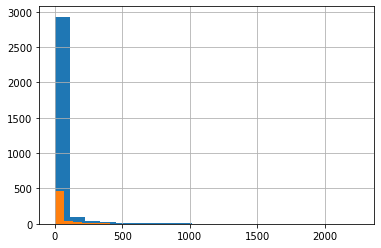

In [31]:
# Let's plot the distribution of this variable within
# the classes

X_test.groupby(y_test)["Informational_Duration"].hist(bins=20)
plt.show()

This variable is very skewed. The permutation method may have picked it up as importance because there is a significant right tail for the blue class.

## Local explanations

Interpreting this tree locally is going to be a bit boring, because it depends only on 1 variable. But anyhow, let's do it.

In [32]:
from treeinterpreter import treeinterpreter as ti

In [33]:
# obtain predictions and explanations

prediction, bias, contributions = ti.predict(surrogate, X_test)

In [34]:
# prediction for the first observation

prediction[0]

array([0., 1.])

The prediction is purchase.

In [35]:
# target

y_test[0]

-1

The model makes the wrong prediction.

We could analyze this further to understand why this happened for this particular observation. That would probably make sense in a real world scenario. With this simple dataset we won't get much in return.

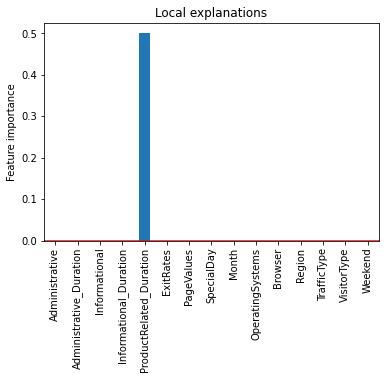

In [36]:
# contributions towards being allocated to no purchase

c = contributions[0][:,1]

pd.Series(c, index=X_train.columns).plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Feature importance")
plt.title("Local explanations")
plt.show()

In [37]:
# let's find an instance of no purchase in the target

y_test.reset_index(drop=True, inplace=True)
y_test[y_test<0]

0      -1
1      -1
2      -1
3      -1
4      -1
       ..
3692   -1
3693   -1
3694   -1
3696   -1
3697   -1
Name: Revenue, Length: 3127, dtype: int64

In [38]:
# This prediction is correct

prediction[4]

array([0.99602339, 0.00397661])

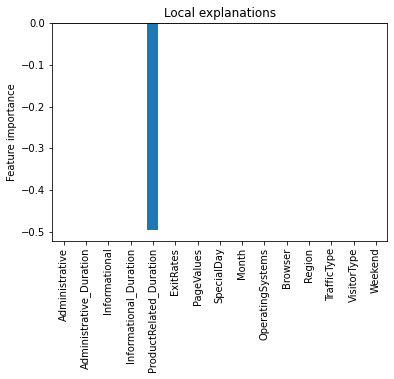

In [39]:
# contributions towards predicting purchase

c = contributions[4][:,1]

pd.Series(c, index=X_train.columns).plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Feature importance")
plt.title("Local explanations")
plt.show()

This is as much as we can do for local explanations with what we covered in the course so far.

In the next section, we will see LIME and SHAP, to explain black boxes locally.

As a homework, you could train a gradient boosting machine, it works much better than the one class svm and compare the insights derived from interpreting the outputs of that model with those of this model.